# Thermovision segmentation

## Dataset

In [1]:
from ultralytics import YOLO

from src.data import read_yolo_dataset
from src.visualizations import plot_images, plot_class_frequencies

In [2]:
CLASSES = ["Person", "Car", "Bicycle", "OtherVechicle", "DontCare"]
COLORS = [(155, 165, 0), (0, 128, 0), (160, 32, 255), (32, 178, 170), (255, 0, 0)]

### Visualizing sample images

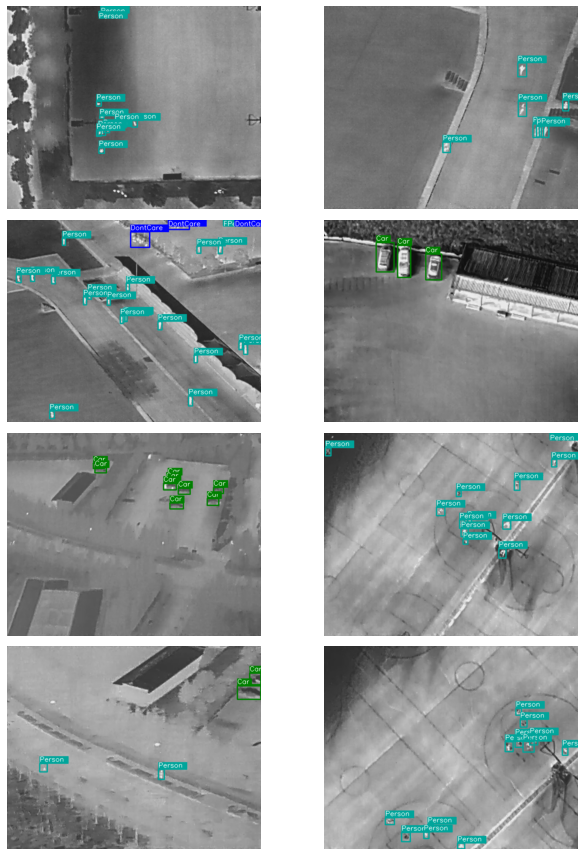

In [3]:
plot_images(
    image_path="data/images/train",
    label_path="data/labels/train",
    num_samples=8,
    classes=CLASSES,
    colors=COLORS,
)

### EDA

[The paper](https://arxiv.org/pdf/2204.03245.pdf) related to the dataset already clearly describes statistics of the dataset, but we performed our own EDA as well. From the characteristics we know that each image is of size (640, 512).

In [4]:
df = read_yolo_dataset("data", CLASSES)
df.head()

,url,annotations,class_id,x_center,y_center,width,height,class_name,split
0,data\labels\test\0_100_30_0_03307.txt,"[1.0, 0.3171875, 0.2451171875, 0.053125, 0.068...",1.0,0.317188,0.245117,0.053125,0.068359,Car,test
1,data\labels\test\0_100_30_0_03307.txt,"[1.0, 0.56015625, 0.201171875, 0.0578125, 0.07...",1.0,0.560156,0.201172,0.057813,0.074219,Car,test
2,data\labels\test\0_100_30_0_03307.txt,"[1.0, 0.1890625, 0.2880859375, 0.046875, 0.052...",1.0,0.189062,0.288086,0.046875,0.052734,Car,test
3,data\labels\test\0_100_30_0_03307.txt,"[1.0, 0.5421875, 0.08203125, 0.03125, 0.04296875]",1.0,0.542188,0.082031,0.031250,0.042969,Car,test
4,data\labels\test\0_100_30_0_03307.txt,"[1.0, 0.65546875, 0.1796875, 0.0453125, 0.0546...",1.0,0.655469,0.179688,0.045312,0.054688,Car,test


In [5]:
df.describe()

,class_id,x_center,y_center,width,height
count,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000
mean,0.735250,0.506489,0.451331,0.044899,0.062266
std,0.837672,0.253180,0.262989,0.037747,0.043709
min,0.000000,0.002344,0.003906,0.004687,0.007812
25%,0.000000,0.314063,0.232422,0.017188,0.035156
50%,1.000000,0.505469,0.439453,0.029687,0.046875
75%,1.000000,0.703125,0.655273,0.059375,0.070312
max,4.000000,0.996875,0.996094,0.473438,0.361328


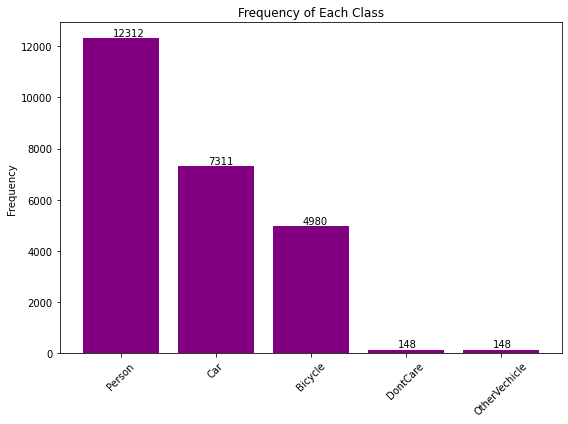

In [7]:
plot_class_frequencies(df)

## Training

In [16]:
model = YOLO("yolov8m.pt")

In [ ]:
results = model.train(
    data="data/dataset.yaml", imgsz=512, epochs=50, batch=16, name="yolov8m_v8_50e"
)